In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Dec  5 11:35:25 2018

@author: wangying
"""

import os
import sys
import operator
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.decomposition import PCA
from Part2_get_data import get_data
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from collections import OrderedDict
from multiprocessing import Process, Lock, Manager
from sklearn.metrics import classification_report


/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
global df1
global df2
#historical_data1_time_Q12005
col_names_svcg = ['loan_sequence_no', 'monthly_reporting_period', 'current_actual_upb', 'current_loan_delinquency_status',
                  'loan_age', 'remaning_months_on_legal_maturity', 'repurchase_flag', 'modification_flag', 'zero_bal_code',
                  'zero_bal_eff_date', 'current_interest_rate', 'current_deferred_upb', 'ddlpi', 'mi_recoveries', 'net_sales_proceeds',
                  'non_mi_recoveries', 'expenses', 'legal_costs', 'maintenance_preservation_cost', 'taxes_insurance', 'misc_expenses',
                  'actual_loss_calc', 'modification_cost']

df1 = pd.read_table('HistoricalInputFiles/historical_data1_time_Q12005.txt',
                    delimiter='|', names=col_names_svcg, index_col=None, nrows=200000, low_memory=False, usecols=list(np.arange(23)))
df2 = pd.read_table('HistoricalInputFiles/historical_data1_time_Q22005.txt',
                    delimiter='|', names=col_names_svcg, index_col=None, nrows=200000, low_memory=False, usecols=list(np.arange(23)))




[[188249   3251]
 [  7719    781]]


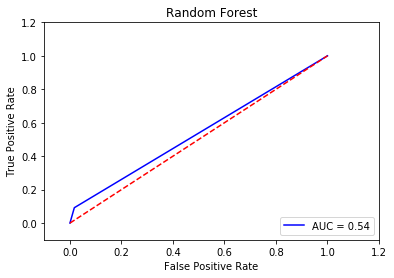

[[190993    507]
 [  7914    586]]


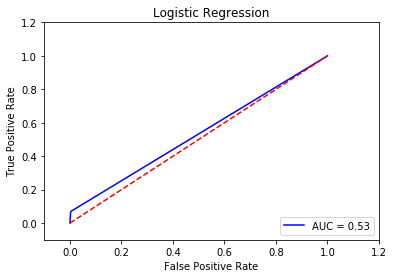

[[191497      3]
 [  8406     94]]


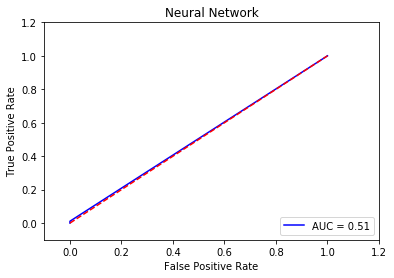

In [3]:
def remove_nan(dff):
    dff.current_loan_delinquency_status = dff.current_loan_delinquency_status.replace('R', '1').astype('float64')

    dff.remaning_months_on_legal_maturity = dff.remaning_months_on_legal_maturity.replace(np.nan, 0)
    dff.remaning_months_on_legal_maturity = dff.remaning_months_on_legal_maturity.astype('category')

    dff.repurchase_flag = dff.repurchase_flag.replace(np.nan, 0)
    dff.repurchase_flag = dff.repurchase_flag.astype('category')

    dff.modification_flag = dff.modification_flag.replace(np.nan, 0)
    dff.modification_flag = dff.modification_flag.astype('category')

    dff.zero_bal_code = dff.zero_bal_code.replace(np.nan, 0)
    dff.zero_bal_code = dff.zero_bal_code.astype('category')

    dff.zero_bal_eff_date = dff.zero_bal_eff_date.replace(np.nan, 0)
    dff.zero_bal_eff_date = dff.zero_bal_eff_date.astype('category')

    dff.current_deferred_upb = dff.current_deferred_upb.replace(np.nan, 0)
    dff.current_deferred_upb = dff.current_deferred_upb.astype('category')

    dff.ddlpi = dff.ddlpi.replace(np.nan, 0)
    dff.ddlpi = dff.ddlpi.astype('category')

    dff.mi_recoveries = dff.mi_recoveries.replace(np.nan, 0)

    dff.net_sales_proceeds = dff.net_sales_proceeds.replace(np.nan, 0)
    dff.net_sales_proceeds = dff.net_sales_proceeds.replace('C', 1)
    dff.net_sales_proceeds = dff.net_sales_proceeds.replace('U', 0)
    dff.net_sales_proceeds.astype('float64')

    dff.non_mi_recoveries = dff.non_mi_recoveries.replace(np.nan, 0)

    dff.expenses = dff.expenses.replace(np.nan, 0)

    dff.legal_costs = dff.legal_costs.replace(np.nan, 0)

    dff.maintenance_preservation_cost = dff.maintenance_preservation_cost.replace(np.nan, 0)
    dff.taxes_insurance = dff.taxes_insurance.replace(np.nan, 0)
    dff.misc_expenses = dff.misc_expenses.replace(np.nan, 0)
    dff.actual_loss_calc = dff.actual_loss_calc.replace(np.nan, 0)
    dff.modification_cost = dff.modification_cost.replace(np.nan, 0)

# remove null
remove_nan(df1)
remove_nan(df2)


# #### Processing the data, Change the numerical features to Dummy variables, Create the target variable,  Create Training and Testing datasets
def process_data():
    # Create target variable function
    def f(row):
        if row['current_loan_delinquency_status'] > 0:
            val = 1
        else:
            val = 0
        return val
    # Create dummy variables
    df1_dummies = pd.get_dummies(df1[['repurchase_flag', 'modification_flag']])
    df2_dummies = pd.get_dummies(df2[['repurchase_flag', 'modification_flag']])

    df1_d = df1.drop(['loan_sequence_no', 'repurchase_flag', 'modification_flag'], axis=1)
    df2_d = df2.drop(['loan_sequence_no', 'repurchase_flag', 'modification_flag'], axis=1)

    global df1_final
    global df2_final
    df1_final = pd.concat([df1_d, df1_dummies], axis=1)
    df2_final = pd.concat([df2_d, df2_dummies], axis=1)

    # create target variable
    df1_final['Deliquent'] = df1_final.apply(f, axis=1)
    df2_final['Deliquent'] = df2_final.apply(f, axis=1)

    # Create training and testing set

    X_train = df1_final.drop(['current_loan_delinquency_status', 'Deliquent'], axis=1)
    y_train = df1_final['Deliquent']

    X_test = df2_final.drop(['current_loan_delinquency_status', 'Deliquent'], axis=1)
    y_test = df2_final['Deliquent']

    X_train = preprocessing.minmax_scale(X_train)  # scale between 0 and 1
    X_test = preprocessing.minmax_scale(X_test)

    return X_train, y_train, X_test, y_test




global X_train
global y_train
global X_test
global y_test
global matrix
global conf_mat_logred
global conf_mat_rf
global conf_mat_nn
global roc_auc_logred
global roc_auc_rf
global roc_auc_nn


X_train, y_train, X_test, y_test = process_data()

'''----------------------------Logistic Regression---------------------------------------------------'''
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting the Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)





    
# random Forest
#def rf(X_train, y_train, X_test, y_test, return_dict_rf):
def rf(X_train, y_train, X_test, y_test):

    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)

    y_train_predicted = rf.predict(X_train)
    y_test_predicted = rf.predict(X_test)

    conf_mat_rf = metrics.confusion_matrix(y_test, y_test_predicted)
    print(conf_mat_rf)

    # Compute ROC curve and AUC (Area under the Curve
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)

    roc_auc_rf = metrics.auc(false_positive_rate, true_positive_rate)
    #return_dict_rf['roc_auc_rf'] = roc_auc_rf
    #return_dict_rf['conf_mat_rf'] = conf_mat_rf

    # Plot ROC Curve
    plt.title("Random Forest")
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = %0.2f' % roc_auc_rf)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    

rf(X_train, y_train, X_test, y_test)

    



def logred(X_train, y_train, X_test, y_test):

    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)

    y_train_predicted = logreg.predict(X_train)
    y_test_predicted = logreg.predict(X_test)

    #print(metrics.classification_report(y_train, y_train_predicted))

    conf_mat_logred = metrics.confusion_matrix(y_test, y_test_predicted)
    print(conf_mat_logred)

    # Compute ROC curve and AUC (Area under the Curve)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)

    roc_auc_logred = metrics.auc(false_positive_rate, true_positive_rate)

    # Plot ROC Curve
    plt.title("Logistic Regression")
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = %0.2f' % roc_auc_logred)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

logred(X_train, y_train, X_test, y_test)



# ### Neural Network

def nn(X_train, y_train, X_test, y_test):

    nn = MLPClassifier()

    nn.fit(X_train, y_train)

    y_train_predicted = nn.predict(X_train)
    y_test_predicted = nn.predict(X_test)

    conf_mat_nn = metrics.confusion_matrix(y_test, y_test_predicted)
    print(conf_mat_nn)

    # Compute ROC curve and AUC (Area under the Curve
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)

    roc_auc_nn = metrics.auc(false_positive_rate, true_positive_rate)

    # Plot ROC Curve
    plt.title("Neural Network")
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = %0.2f' % roc_auc_nn)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

nn(X_train, y_train, X_test, y_test)